# Basic characterizations of UA Q1
### using Experiment and Analysis classes

In [4]:
a = [1,2,3]
b = [4,5,6]
for i in [a,b]:
    print(i[0])

1
4


In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
res_index = 0 # for UA Q1
flux_index = 0 # for UA Q1

2023-10-27 10:09:48,560 - qm - INFO     - Starting session: e3d70c21-39f2-47e4-ba39-d2a0350a1b65


SyntaxError: invalid syntax (ExperimentClass_2D.py, line 805)

In [ ]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

Error: Unknown request.

Request sent to server: An error occurred when performing the following operation:
Set value

Instrument: Rohde&Schwarz RF Source - IP: 192.168.88.2
Quantity: Frequency

Error message:
The instrument driver is not running.

In [ ]:
Experiment.octave_calibration(qubit_index,res_index,flux_index)

## Time of flight

In [ ]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 1E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [ ]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += -0.000341
machine.global_parameters.con1_downconversion_offset_Q += -0.000633
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [ ]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, n_avg = 5E3, cd_time = 5E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)

In [ ]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [ ]:
res_freq_sweep = np.arange(7.254E9,7.267E9 + 1.0,0.2E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, n_avg = 1E3, cd_time = 10E3)

In [ ]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [ ]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [ ]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [ ]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

In [ ]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, n_avg = 5E3, cd_time = 5E3, plot_flag = False, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

In [ ]:
#qubit_freq_sweep = np.arange(6.30E9,6.60E9+1,1E6)
qubit_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-50E6, 50E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 2E3, cd_time = 10E3, plot_flag = False)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 100E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

## Rabi

### time rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
                                          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 10E3, plot_flag = False)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[0] = 100
machine = Analysis.set_machine(machine)

### power rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 2E3, cd_time = 10E3, plot_flag = False)

In [ ]:
%matplotlib qt
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [ ]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.6,0.6+1E-4,0.05)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

In [ ]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

In [ ]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [4]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [ ]:
# try the experiment
%matplotlib qt
ff_sweep = np.arange(0.0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-100E6, 100E6 + 1, 2E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [5]:
# try the experiment
%matplotlib qt
q_freq_max = np.polyval(machine.qubits[qubit_index].tuning_curve, 0.0) * 1E6
#ff_sweep_abs = np.arange(0.0,0.3+1E-4,0.05)
qubit_freq_sweep = np.arange(q_freq_max, 4E9, -4E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, n_avg = 4E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

some fast flux > 0.5V, removed from experiment run
seg (0 - 126) / 459 ...
Octave calibration starts...
------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
------------------------------------- Calibrates q0 for (LO, IF) = (6.137 GHz,  290.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
------------------------------------- Calibrates q0 for (LO, IF) = (6.137 GHz, 290.000 MHz)
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1345.95s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1346.12s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1346.28s
seg (126 - 252) / 459 ...
Octave calibration starts...
------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
------------------------------------- Cal

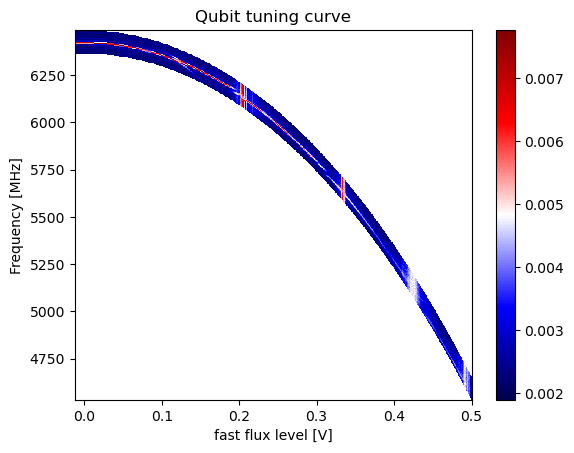

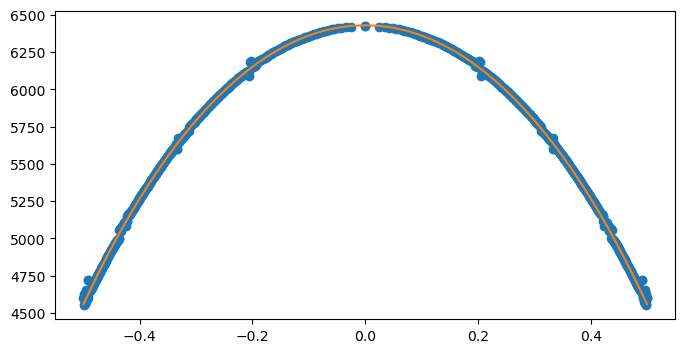

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [6]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### run a few more sections, where the signal above was bad likely due to octave calibrations

In [ ]:
# try the experiment
%matplotlib qt
q_freq_max = np.polyval(machine.qubits[qubit_index].tuning_curve, 0.0) * 1E6
qubit_freq_sweep = np.arange(6.2E9, 6.0E9, -4E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, n_avg = 4E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

seg (0 - 50) / 50 ...
2023-10-27 09:10:44,212 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-27 09:10:44,222 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-10-27 09:10:50,463 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (5.910 GHz, 290.000 MHz)
2023-10-27 09:11:02,988 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### test